# Ch 4. 模型擬合、評估與超參數調校
## 4-3. 評估模型效能
[4-3-1. 學習曲線與驗證曲線](#sec4_3_1)  
[4-3-2. P-R 曲線與 ROC 曲線](#sec4_3_2)  
***

<a id='sec4_3_1'></a>
## 4-3-1. 學習曲線與驗證曲線

In [1]:
import warnings
# 忽略警告訊息
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

df = pd.read_csv('Pokemon_894_13.csv')
df['hasType2'] = df['Type2'].notnull().astype(int)
df.take([100,200,300])

,Number,Name,Type1,Type2,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary,hasType2
100,93,鬼斯通,Ghost,Poison,45,50,45,115,55,95,1,False,1
200,185,樹才怪,Rock,NaN,70,100,115,30,65,30,2,False,0
300,277,大王燕,Normal,Flying,60,85,60,50,50,125,3,False,1


In [2]:
pipe_lr = make_pipeline(StandardScaler(), 
                        LogisticRegression())
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [3]:
from sklearn.model_selection import train_test_split

X, y = df.loc[:, 'HP':'Speed'], df['hasType2']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, 
                     random_state=0)
print(X_train.shape)
print(X_test.shape)

(715, 6)
(179, 6)


### 學習曲線

In [4]:
import numpy as np
from sklearn.model_selection import learning_curve

size = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, valid_scores = \
    learning_curve(estimator=pipe_lr,
                   X=X_train, y=y_train,
                   train_sizes=size,
                   cv=10, n_jobs=-1)
train_scores[:3, :]

array([[0.5625    , 0.5625    , 0.5625    , 0.5625    , 0.5625    ,
        0.5625    , 0.5625    , 0.5625    , 0.5625    , 0.5625    ],
       [0.5625    , 0.6015625 , 0.5625    , 0.5625    , 0.5625    ,
        0.5625    , 0.5625    , 0.5625    , 0.5625    , 0.5625    ],
       [0.60416667, 0.59375   , 0.578125  , 0.57291667, 0.57291667,
        0.57291667, 0.57291667, 0.57291667, 0.57291667, 0.57291667]])

In [5]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
valid_scores_mean[:3]

array([0.48262911, 0.52323944, 0.52746479])

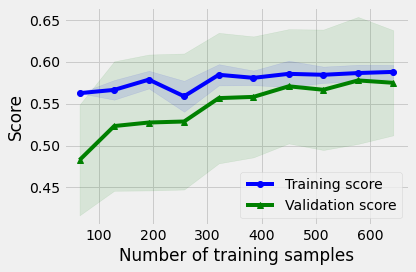

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.plot(train_sizes, train_scores_mean, 
         color='blue', marker='o', 
         label='Training score')
plt.fill_between(train_sizes, 
                 train_scores_mean+train_scores_std, 
                 train_scores_mean-train_scores_std, 
                 color='blue', alpha=.1)
plt.plot(train_sizes, valid_scores_mean, 
         color='green', marker='^', 
         label='Validation score')
plt.fill_between(train_sizes, 
                 valid_scores_mean+valid_scores_std, 
                 valid_scores_mean-valid_scores_std, 
                 color='green', alpha=.1)
plt.xlabel('Number of training samples')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.tight_layout()

### 驗證曲線

In [7]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-4, 4, 9)
train_scores, valid_scores = validation_curve(
    LogisticRegression(penalty='l1', solver='saga'), 
    X, y, param_name="C", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=-1)
train_scores[:3, :]

array([[0.52860697, 0.52860697, 0.47139303, 0.52985075, 0.52919255,
        0.52919255, 0.52919255, 0.52919255, 0.52919255, 0.52919255],
       [0.52860697, 0.52985075, 0.52985075, 0.53233831, 0.53167702,
        0.53043478, 0.53043478, 0.53167702, 0.53043478, 0.53167702],
       [0.53606965, 0.5261194 , 0.55597015, 0.53233831, 0.53540373,
        0.53167702, 0.53540373, 0.54409938, 0.53540373, 0.53167702]])

In [8]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
valid_scores_mean[:3]

array([0.52240949, 0.53131086, 0.52463171])

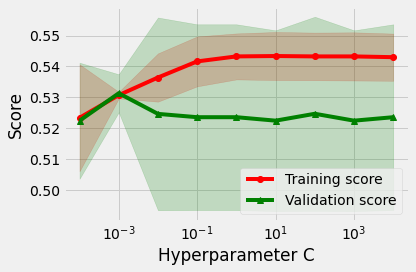

In [9]:
plt.semilogx(param_range, train_scores_mean, 
             label="Training score", color="r", 
             marker='o')
plt.fill_between(param_range, 
                 train_scores_mean-train_scores_std,
                 train_scores_mean+train_scores_std, 
                 alpha=0.2, color="r")
plt.semilogx(param_range, valid_scores_mean, 
             label="Validation score", color="g", 
             marker='^')
plt.fill_between(param_range, 
                 valid_scores_mean-valid_scores_std,
                 valid_scores_mean+valid_scores_std, 
                 alpha=0.2, color="g")
plt.legend(loc='lower right')
plt.xlabel('Hyperparameter C')
plt.ylabel('Score')
plt.tight_layout()

<a id='sec4_3_2'></a>
## 4-3-2. P-R 曲線與 ROC 曲線

In [10]:
from sklearn.metrics import average_precision_score

pipe_lr.fit(X_train, y_train)
y_score = pipe_lr.decision_function(X_test)
# 計算 AP 值
ap = average_precision_score(y_test, y_score)
print('Average precision-recall score: %.2f' %ap)

Average precision-recall score: 0.73


### P-R 曲線

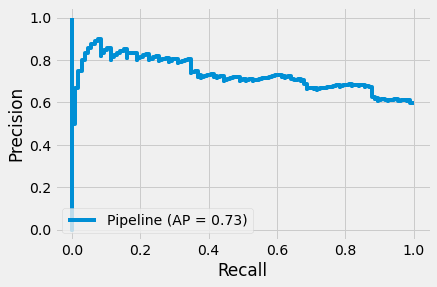

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(pipe_lr, X_test, y_test)

### ROC 曲線

In [12]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
roc_auc

0.6673559059188421

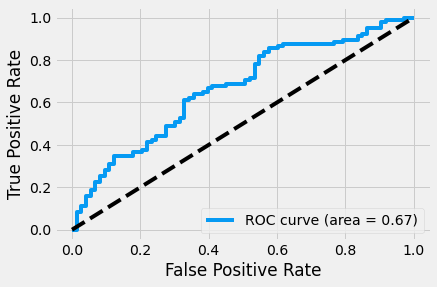

In [13]:
plt.plot(fpr, tpr, color='xkcd:azure', 
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")